In [4]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image

# Load pre-trained ResNet50
resnet = models.resnet50(pretrained=True, progress=False)

# Remove the last fully connected layer (fc)
resnet.fc = nn.Identity()

# Define the image transformations
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load an image
img = Image.open("../../GTEx/temp_input/14_57.png").convert('RGB')
img_t = transform(img).unsqueeze(0)  # Add batch dimension

# Set model to evaluation mode and extract features
resnet.eval()
with torch.no_grad():
    features = resnet(img_t)
    print(features.shape)  # This will typically be (1, 2048) for ResNet50


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /usr3/graduate/wtzheng/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


torch.Size([1, 2048])


# HoVer-Net Output Notebook

This repository enables the segmentation of nuclei in H&E whole-slide images (WSIs). For inference, we have incorporated two modes:

- Tile processing mode
- WSI processing mode

For tile processing, the input must be in a standard image format, such as `.jpg` or `.png`. <br />
For WSI processing, the input must be an [OpenSlide](https://openslide.org/) supported whole-slide image.

- Both tile and wsi processing modes output a `.json` file that contains:
        - bounding box coordinates for each nucleus
        - centroid coordinates for each nucleus
        - contour coordinates for each nucleus 
        - nucleus type predictions
        - per class probabilities for each nucleus (optional)
- tile mode also output a `.mat` and overlay file. The `.mat` file contains:
        - raw output of network (optional)
        - instance map containing values from 0 to N, where N is the number of nuclei
        - list of length N containing predictions for each nucleus
- wsi mode also produces a low resolution thumbnail and a tissue mask

In this notebook, we demonstrate how to utilise the output generated by these two different settings.

In [1]:
# load the libraries

import sys
sys.path.append('../')

import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import scipy.io as sio
import cv2
import json
import openslide

from misc.wsi_handler import get_file_handler
from misc.viz_utils import visualize_instances_dict

In [2]:
# first, we shall set the image tile, WSI and output paths.

tile_path = '../../GTEx/temp_input/14_57.png'
tile_json_path = '../../GTEx/temp_input/json/14_57.json'
# tile_mat_path = '../dataset/sample_tiles/pred/mat/'
# tile_overlay_path = '../dataset/sample_tiles/pred/overlay/'
# wsi_path = '../dataset/sample_wsis/wsi/'
# wsi_json_path = '../dataset/sample_wsis/out/'

## Tile Processing Output

First let's view the 2D output from tile processing mode, that is stored in a `.mat` file.

We observe that the values range from 0 (background) to N where N is the number of classes. See below what these values refer to for different datasets.

## CoNSeP

1) Epithelial <br />
2) Inflammatory <br />
3) Spindle-Shaped <br />
4) Miscellaneous

## PanNuke

1) Neoplastic <br />
2) Inflammatory <br />
3) Connective <br />
4) Dead <br />
5) Non-Neoplastic Epithelial 

## MoNuSAC

1) Epithelial <br />
2) Lymphocyte <br />
3) Macrophage <br />
4) Neutrophil

**In this example we use a checkpoint trained on the PanNuke dataset**

Now, let's view the contents of the `.json` file.

In [46]:
# load the json file and add the contents to corresponding lists

# json_path = tile_json_path + basename + '.json'
json_path = tile_json_path

bbox_list = []
centroid_list = []
contour_list = [] 
type_list = []

with open(json_path) as json_file:
    data = json.load(json_file)
    mag_info = data['mag']
    nuc_info = data['nuc']
    for inst in nuc_info:
        inst_info = nuc_info[inst]
        inst_bbox = inst_info['bbox']
        bbox_list.append(inst_bbox)

def crop_images(large_image_path, coordinates):
    
    cropped_img = []
    
    large_image = cv2.imread(large_image_path)
    
    if large_image is None:
        print("Error loading image")
        return []
    
    large_image = cv2.cvtColor(large_image, cv2.COLOR_BGR2RGB)  # Convert to RGB
    
    for bbox in bbox_list:
    
        x1, y1 = bbox[0]
        x2, y2 = bbox[1]

        cropped_img.append(large_image[x1:x2, y1:y2, :])
        
    return cropped_img
    
#     for i, bbox in enumerate(bbox_list):
#         x1, y1 = bbox[0]
#         x2, y2 = bbox[1]

#         # Crop the image using correct indexing for numpy arrays
#         cropped_image = large_image[x1:x2, y1:y2, :]
        
#         # Save the cropped image
#         save_path = os.path.join('../../GTEx/cropped', f"cropped_{i}.png")
#         cv2.imwrite(save_path, cv2.cvtColor(cropped_image, cv2.COLOR_RGB2BGR))
    

proc_img = crop_images(tile_path, bbox_list)

In [47]:
proc_img[0]

array([[[ 55,  24,  67],
        [ 56,  25,  68],
        [ 58,  26,  69],
        [ 61,  28,  70],
        [ 58,  23,  70],
        [ 52,  14,  69],
        [ 51,  13,  72],
        [ 54,  20,  76],
        [ 61,  29,  81],
        [ 67,  34,  86],
        [ 72,  38,  89],
        [ 75,  38,  87],
        [ 72,  36,  83],
        [ 66,  33,  77],
        [ 59,  31,  73],
        [ 54,  31,  72],
        [ 58,  36,  79]],

       [[ 53,  24,  66],
        [ 54,  24,  67],
        [ 56,  25,  68],
        [ 59,  26,  69],
        [ 57,  22,  69],
        [ 53,  16,  68],
        [ 53,  16,  71],
        [ 56,  22,  74],
        [ 62,  29,  79],
        [ 68,  34,  83],
        [ 72,  36,  86],
        [ 72,  35,  85],
        [ 69,  32,  81],
        [ 63,  29,  76],
        [ 58,  28,  74],
        [ 56,  29,  74],
        [ 64,  36,  81]],

       [[ 51,  24,  66],
        [ 51,  23,  65],
        [ 53,  22,  65],
        [ 55,  22,  66],
        [ 56,  20,  67],
        [ 55,  18,  6

In [44]:
json_filename = '12_22.json'
image_basename = os.path.splitext(json_filename)[0] + '.png'
image_basename

'12_22.png'

In [38]:
import torch
import torchvision.models as models
import torchvision.transforms.functional as TF
import numpy as np
import cv2

# Load the pre-trained ResNet model
model = models.resnet50(pretrained=True, progress=False)
model.eval()

# Modify the model to remove the last fully connected layer
model = torch.nn.Sequential(*(list(model.children())[:-1]))

# Create a placeholder for the features
features = torch.empty((len(proc_img), 2048))  # Corrected dimension

# Define normalization mean and std
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

# Process the images
for i, image in enumerate(proc_img):
    # Convert from BGR (OpenCV default) to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Resize the image to (224, 224) as expected by the model
    image = cv2.resize(image, (224, 224))

    # Convert the numpy array to a torch tensor
    image = torch.tensor(image).permute(2, 0, 1).float() / 255.  # Rearrange channels to CxHxW and normalize to [0, 1]

    # Normalize the image tensor
    image = TF.normalize(image, mean=mean, std=std)

    # Add a batch dimension
    image = image.unsqueeze(0)

    # Forward pass to get features
    with torch.no_grad():
        output = model(image)
        features[i, :] = output.squeeze()  # Use squeeze to remove extra dimensions

# Verify the size of the feature tensor
print(features.size())

torch.Size([163, 2048])


In [41]:
torch.save(features, '../../GTEx/sample_features.pt')

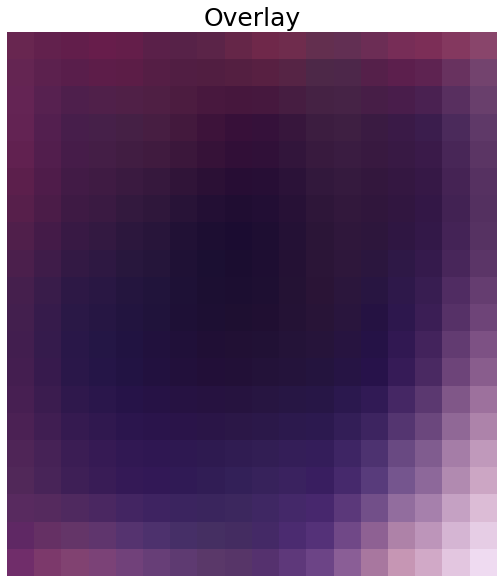

In [32]:
image_file = tile_path
image = cv2.imread(image_file)
# convert from BGR to RGB
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# get a single contour, bounding box and centroid and visualise
# rand_nucleus = np.random.randint(0, len(centroid_list))
# rand_centroid = centroid_list[rand_nucleus]
# rand_bbox = bbox_list[rand_nucleus]
# rand_contour = contour_list[rand_nucleus]

# draw the overlays
overlay = image.copy()

for bbox in bbox_list:
    overlay = cv2.rectangle(overlay.astype('uint8'), (bbox[0][1], bbox[0][0]), (bbox[1][1], bbox[1][0]), (255,0,0), 1)

# cropped_images = [image]

# plot the cropped overlay
plt.figure(figsize=(10,10))

plt.imshow(overlay)
# plt.imshow(proc_img[120])
plt.axis('off')
plt.title('Overlay', fontsize=25)
plt.show()

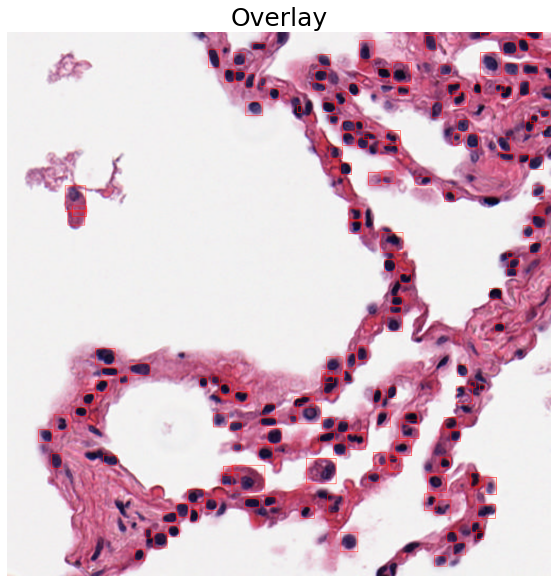

In [21]:
image_file = tile_path
image = cv2.imread(image_file)
# convert from BGR to RGB
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# get a single contour, bounding box and centroid and visualise
# rand_nucleus = np.random.randint(0, len(centroid_list))
# rand_centroid = centroid_list[rand_nucleus]
# rand_bbox = bbox_list[rand_nucleus]
# rand_contour = contour_list[rand_nucleus]

# draw the overlays
overlay = image.copy()

for bbox in bbox_list:
    overlay = cv2.rectangle(overlay.astype('uint8'), (bbox[0][1], bbox[0][0]), (bbox[1][1], bbox[1][0]), (255,0,0), 1)


# plot the cropped overlay
plt.figure(figsize=(10,10))

plt.imshow(overlay)
plt.axis('off')
plt.title('Overlay', fontsize=25)
plt.show()